In [1]:
import time
import math
import os
import torch.nn as nn

import torch.onnx
import torch
from torch.autograd import Variable
import torch.optim as optim

import model as rnn_model
import data

In [2]:
args_seed = 1234
args_temperature = 1.
args_data = '../data/wikitext-2'
args_model = 'LSTM'
args_emsize = 200
args_nhid = 200
args_nlayers = 2
args_lr = 20
args_clip = 0.25
args_epochs = 40
args_batch_size = 20
args_bptt = 35
args_dropout = 0.2
args_log_interval = 200
args_save = 'model.pt'
args_save_state = 'model_state.pt'
args_tied = True

In [3]:
torch.manual_seed(args_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'using device: {device}')

using device: cuda


In [4]:
###############################################################################
# Load data
###############################################################################

corpus = data.Corpus(args_data)

In [5]:
# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.

def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

eval_batch_size = 10
train_data = batchify(corpus.train, args_batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

In [6]:
###############################################################################
# Build the model
###############################################################################

ntokens = len(corpus.dictionary)
model = rnn_model.RNNModel(args_model, ntokens, args_emsize, args_nhid, args_nlayers, args_dropout, args_tied).to(device)

criterion = nn.CrossEntropyLoss()

In [7]:
###############################################################################
# Use Adam optimizer
###############################################################################

# create your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
###############################################################################
# Training code
###############################################################################

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [9]:
# get_batch subdivides the source data into chunks of length args.bptt.
# If source is equal to the example output of the batchify function, with
# a bptt-limit of 2, we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the batchify function. The chunks are along dimension 0, corresponding
# to the seq_len dimension in the LSTM.

def get_batch(source, i):
    seq_len = min(args_bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target


def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(eval_batch_size)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, args_bptt):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
            hidden = repackage_hidden(hidden)
    return total_loss / len(data_source)


def train():
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(args_batch_size)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, args_bptt)):
        data, targets = get_batch(train_data, i)
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        hidden = repackage_hidden(hidden)
        optimizer.zero_grad()   # zero the gradient buffers
        output, hidden = model(data, hidden)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        optimizer.step()    # Does the update
        total_loss += loss.item()

        if batch % args_log_interval == 0 and batch > 0:
            cur_loss = total_loss / args_log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch, len(train_data) // args_bptt, 
                elapsed * 1000 / args_log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()


In [10]:
# Loop over epochs.
best_val_loss = None

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, args_epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(val_data)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(args_save, 'wb') as f:
                torch.save(model, f)
            ## Save State Dictionary
            with open(args_save_state, 'wb') as f:
                torch.save(model.state_dict(), f)
            best_val_loss = val_loss

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

| epoch   1 |   200/ 2983 batches | lr 20.00 | ms/batch 29.01 | loss  7.75 | ppl  2314.22
| epoch   1 |   400/ 2983 batches | lr 20.00 | ms/batch 27.05 | loss  6.80 | ppl   896.91
| epoch   1 |   600/ 2983 batches | lr 20.00 | ms/batch 27.26 | loss  6.42 | ppl   613.78
| epoch   1 |   800/ 2983 batches | lr 20.00 | ms/batch 27.20 | loss  6.30 | ppl   545.85
| epoch   1 |  1000/ 2983 batches | lr 20.00 | ms/batch 27.02 | loss  6.20 | ppl   491.94
| epoch   1 |  1200/ 2983 batches | lr 20.00 | ms/batch 26.98 | loss  6.15 | ppl   470.22
| epoch   1 |  1400/ 2983 batches | lr 20.00 | ms/batch 26.89 | loss  6.09 | ppl   441.54
| epoch   1 |  1600/ 2983 batches | lr 20.00 | ms/batch 27.13 | loss  6.09 | ppl   440.18
| epoch   1 |  1800/ 2983 batches | lr 20.00 | ms/batch 27.55 | loss  5.97 | ppl   391.36
| epoch   1 |  2000/ 2983 batches | lr 20.00 | ms/batch 27.08 | loss  5.98 | ppl   394.58
| epoch   1 |  2200/ 2983 batches | lr 20.00 | ms/batch 27.05 | loss  5.88 | ppl   356.09
| epoch   

| epoch   6 |  1600/ 2983 batches | lr 5.00 | ms/batch 26.97 | loss  5.02 | ppl   150.83
| epoch   6 |  1800/ 2983 batches | lr 5.00 | ms/batch 27.11 | loss  4.94 | ppl   139.38
| epoch   6 |  2000/ 2983 batches | lr 5.00 | ms/batch 27.09 | loss  4.99 | ppl   147.03
| epoch   6 |  2200/ 2983 batches | lr 5.00 | ms/batch 27.03 | loss  4.90 | ppl   133.81
| epoch   6 |  2400/ 2983 batches | lr 5.00 | ms/batch 27.09 | loss  4.94 | ppl   139.18
| epoch   6 |  2600/ 2983 batches | lr 5.00 | ms/batch 27.12 | loss  4.95 | ppl   140.48
| epoch   6 |  2800/ 2983 batches | lr 5.00 | ms/batch 27.06 | loss  4.92 | ppl   137.29
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 83.67s | valid loss  5.28 | valid ppl   196.72
-----------------------------------------------------------------------------------------
| epoch   7 |   200/ 2983 batches | lr 1.25 | ms/batch 27.23 | loss  4.90 | ppl   134.71
| epoch   7 |   400/ 2983 batches 

| epoch  12 |   200/ 2983 batches | lr 0.00 | ms/batch 27.36 | loss  4.74 | ppl   114.11
| epoch  12 |   400/ 2983 batches | lr 0.00 | ms/batch 27.13 | loss  4.79 | ppl   120.79
| epoch  12 |   600/ 2983 batches | lr 0.00 | ms/batch 27.16 | loss  4.67 | ppl   107.04
| epoch  12 |   800/ 2983 batches | lr 0.00 | ms/batch 26.96 | loss  4.73 | ppl   113.24
| epoch  12 |  1000/ 2983 batches | lr 0.00 | ms/batch 27.12 | loss  4.74 | ppl   114.48
| epoch  12 |  1200/ 2983 batches | lr 0.00 | ms/batch 26.92 | loss  4.75 | ppl   116.05
| epoch  12 |  1400/ 2983 batches | lr 0.00 | ms/batch 26.96 | loss  4.75 | ppl   115.07
| epoch  12 |  1600/ 2983 batches | lr 0.00 | ms/batch 26.99 | loss  4.82 | ppl   123.76
| epoch  12 |  1800/ 2983 batches | lr 0.00 | ms/batch 27.17 | loss  4.76 | ppl   116.23
| epoch  12 |  2000/ 2983 batches | lr 0.00 | ms/batch 27.18 | loss  4.82 | ppl   123.45
| epoch  12 |  2200/ 2983 batches | lr 0.00 | ms/batch 27.03 | loss  4.70 | ppl   109.70
| epoch  12 |  2400/ 

| epoch  17 |  1800/ 2983 batches | lr 0.00 | ms/batch 27.28 | loss  4.67 | ppl   107.05
| epoch  17 |  2000/ 2983 batches | lr 0.00 | ms/batch 26.97 | loss  4.74 | ppl   114.45
| epoch  17 |  2200/ 2983 batches | lr 0.00 | ms/batch 27.01 | loss  4.63 | ppl   102.40
| epoch  17 |  2400/ 2983 batches | lr 0.00 | ms/batch 27.09 | loss  4.65 | ppl   104.42
| epoch  17 |  2600/ 2983 batches | lr 0.00 | ms/batch 27.01 | loss  4.72 | ppl   111.61
| epoch  17 |  2800/ 2983 batches | lr 0.00 | ms/batch 26.99 | loss  4.65 | ppl   105.08
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 83.59s | valid loss  5.22 | valid ppl   185.27
-----------------------------------------------------------------------------------------
| epoch  18 |   200/ 2983 batches | lr 0.00 | ms/batch 27.16 | loss  4.66 | ppl   105.56
| epoch  18 |   400/ 2983 batches | lr 0.00 | ms/batch 27.04 | loss  4.71 | ppl   111.08
| epoch  18 |   600/ 2983 batches 

| epoch  23 |   200/ 2983 batches | lr 0.00 | ms/batch 27.31 | loss  4.63 | ppl   102.50
| epoch  23 |   400/ 2983 batches | lr 0.00 | ms/batch 28.02 | loss  4.67 | ppl   106.80
| epoch  23 |   600/ 2983 batches | lr 0.00 | ms/batch 28.65 | loss  4.54 | ppl    94.07
| epoch  23 |   800/ 2983 batches | lr 0.00 | ms/batch 30.30 | loss  4.60 | ppl    99.32
| epoch  23 |  1000/ 2983 batches | lr 0.00 | ms/batch 28.91 | loss  4.61 | ppl   100.79
| epoch  23 |  1200/ 2983 batches | lr 0.00 | ms/batch 27.75 | loss  4.64 | ppl   103.86
| epoch  23 |  1400/ 2983 batches | lr 0.00 | ms/batch 28.07 | loss  4.67 | ppl   106.22
| epoch  23 |  1600/ 2983 batches | lr 0.00 | ms/batch 27.51 | loss  4.74 | ppl   114.88
| epoch  23 |  1800/ 2983 batches | lr 0.00 | ms/batch 27.41 | loss  4.63 | ppl   102.74
| epoch  23 |  2000/ 2983 batches | lr 0.00 | ms/batch 30.12 | loss  4.68 | ppl   107.78
| epoch  23 |  2200/ 2983 batches | lr 0.00 | ms/batch 28.42 | loss  4.57 | ppl    96.68
| epoch  23 |  2400/ 

In [11]:
# Load the best saved model.
with open(args_save, 'rb') as f:
    model = torch.load(f)
    # after load the rnn params are not a continuous chunk of memory
    # this makes them a continuous chunk, and will speed up forward pass
    model.rnn.flatten_parameters()

# Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)


| End of training | test loss  5.11 | test ppl   165.73


# Try to generate with this model now

In [12]:
args_data = '../data/wikitext-2'
args_checkpoint = './model.pt'
args_state_dict = './model_state.pt'
args_outf = 'generated.txt'
args_words = 1000
args_seed = 1234
args_temperature = 1.0
args_log_interval = 100

In [13]:
# Set the random seed manually for reproducibility.
torch.manual_seed(args_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [14]:
if args_temperature < 1e-3:
    print("args_temperature has to be greater or equal 1e-3")


In [15]:
corpus = data.Corpus(args_data)
ntokens = len(corpus.dictionary)

In [16]:
# with open(args_checkpoint, 'rb') as f:
#     model = torch.load(f).to(device)
ntokens = len(corpus.dictionary)
model = rnn_model.RNNModel(args_model, ntokens, args_emsize, args_nhid, args_nlayers, args_dropout, args_tied).to(device)


In [17]:
hidden = model.init_hidden(1)
input = torch.randint(ntokens, (1, 1), dtype=torch.long).to(device)

In [18]:
model.eval()

RNNModel(
  (drop): Dropout(p=0.2)
  (encoder): Embedding(33278, 200)
  (rnn): LSTM(200, 200, num_layers=2, dropout=0.2)
  (decoder): Linear(in_features=200, out_features=33278, bias=True)
)

In [19]:
with open(args_outf, 'w') as outf:
    with torch.no_grad():  # no tracking history
        for i in range(args_words):
            output, hidden = model(input, hidden)
            word_weights = output.squeeze().div(args_temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            input.fill_(word_idx)
            word = corpus.dictionary.idx2word[word_idx]

            outf.write(word + ('\n' if i % 20 == 19 else ' '))

            if i % args_log_interval == 0:
                print('| Generated {}/{} words'.format(i, args_words))

| Generated 0/1000 words
| Generated 100/1000 words
| Generated 200/1000 words
| Generated 300/1000 words
| Generated 400/1000 words
| Generated 500/1000 words
| Generated 600/1000 words
| Generated 700/1000 words
| Generated 800/1000 words
| Generated 900/1000 words


In [20]:
model.state_dict()

OrderedDict([('encoder.weight',
              tensor([[-0.0741, -0.0362,  0.0747,  ...,  0.0200,  0.0351, -0.0910],
                      [ 0.0956,  0.0994, -0.0807,  ...,  0.0909,  0.0632, -0.0181],
                      [ 0.0822, -0.0848, -0.0954,  ..., -0.0596, -0.0452,  0.0552],
                      ...,
                      [-0.0194, -0.0107,  0.0577,  ..., -0.0625, -0.0364, -0.0657],
                      [-0.0690, -0.0153, -0.0525,  ...,  0.0393,  0.0737,  0.0737],
                      [-0.0307,  0.0043,  0.0422,  ..., -0.0410, -0.0566, -0.0087]],
                     device='cuda:0')),
             ('rnn.weight_ih_l0',
              tensor([[ 0.0594,  0.0334, -0.0147,  ...,  0.0363,  0.0219, -0.0698],
                      [-0.0242,  0.0591,  0.0053,  ...,  0.0654,  0.0063,  0.0345],
                      [-0.0500,  0.0657,  0.0313,  ..., -0.0396,  0.0262, -0.0506],
                      ...,
                      [ 0.0207,  0.0382, -0.0321,  ...,  0.0099,  0.0692, -0.0553],

## What do the embeddings look like?

In [24]:
import scipy
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/Users/andrew/miniconda3/envs/breadventure/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [25]:
model.state_dict().keys()

odict_keys(['encoder.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'decoder.weight', 'decoder.bias'])

In [26]:
model.state_dict()['encoder.weight'].shape

torch.Size([33278, 200])

In [27]:
embeds = model.state_dict()['encoder.weight']

In [29]:
np.array(list(corpus.dictionary.word2idx.keys()))

array(['<eos>', '=', 'Valkyria', ..., 'Nests', 'flea', 'gallinae'],
      dtype='<U20')

In [30]:
some_words = ['flour', 'water', 'bread', 'coffee', 'driving', 'car', 'horse', 'chicken', 'bird', 'cow', 'leg']
some_words

['flour',
 'water',
 'bread',
 'coffee',
 'driving',
 'car',
 'horse',
 'chicken',
 'bird',
 'cow',
 'leg']

In [31]:
some_idxs = [corpus.dictionary.word2idx[word] for word in some_words]

In [32]:
print(embeds[some_idxs].shape)
np.array(embeds[some_idxs])

torch.Size([11, 200])


array([[-0.02211978, -0.04078216, -0.05417591, ...,  0.01053627,
         0.01473385,  0.01968203],
       [-0.05243944,  0.03832772, -0.00496112, ...,  0.00311856,
         0.09399863,  0.08048058],
       [ 0.03838401, -0.00253663,  0.00355909, ..., -0.05477671,
        -0.00039558, -0.06522658],
       ...,
       [ 0.05418205, -0.02397664, -0.03950721, ...,  0.01659943,
        -0.0940535 , -0.01276223],
       [ 0.0213261 ,  0.05090193,  0.06393952, ...,  0.09761625,
         0.06812478,  0.00376463],
       [-0.02371339, -0.08695342,  0.04383665, ...,  0.0956846 ,
        -0.08986057,  0.0581846 ]], dtype=float32)

In [33]:
tsne = TSNE(n_components=2, random_state=123)
#np.set_printoptions(suppress=True)
Y = tsne.fit_transform(np.array(embeds[some_idxs]))


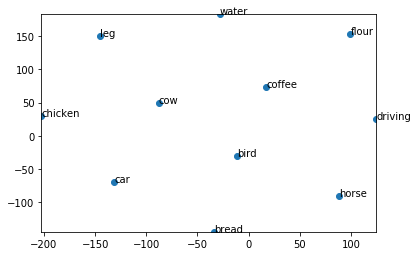

In [34]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)

for label, x, y in zip(some_words, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()

Well this is obviously terrible. It must not have found any association. Looking at the generated words, it doesn't make much sense so this isn't terribly surprising. Probably R-200 for embedding space is too small.